In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
from findiff import FinDiff
from scipy.optimize import fsolve
import sys
sys.path.insert(0,'.')
import pandas as pd

In [9]:
# Fixing all the constants of the Problem
M = 1             # Mass of blackhole
n = 2**12         # no of grid points
h = 1/n           # Step size in z (our compact variable)
a = 0.0           # Kreiss Oliger Dissipation coefficient

# Parameters of the potential
mu = 0
lam = 0

# Potential function
def V(x):
    return mu * x ** 2 + lam * x ** 4 
# Derivative of potential function
def dV(x):
    return 2 * mu * x + 4 * lam * x ** 3

# Epsilon factor
e = 1             

 The position of initial apparant horizon is r = 1.4941939185522344 
 z = 0.5990688644688644 
 m = 2454


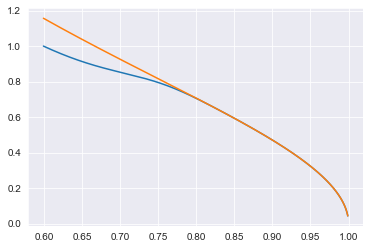

In [10]:

# We will try to solve for the function zeta using explicit method at the initial time
# Kriess Oliger Dissipation function has also been employed

def zeta_zero(p_given):

    p = p_given
    
    err = 10**(-3)                                            # Putting a cutoff to our space 
    Z = np.linspace(err, 1 - err, n)
    R = M * Z / (1 - Z)
                        
    # Specifying initial values of the Field namely phi and pi
    phi = np.zeros(n) 

    for i in range(0, n):
        expo = Z[i]**2 / ( p**2 * (1 - Z[i])**2 )
        if expo <= 100 :
            phi[i] =  0.5 * np.exp(-expo)

    # Specifying the initial value of pi 
    pi = np.zeros(n)
    
    # Defining the derivative operator using FinDiff
    dz = Z[1] - Z[0]
    d_dz = FinDiff(0, dz, 1, acc=4)

    dphi = d_dz(phi) / d_dz(R)
    d2phi = d_dz(dphi) / d_dz(R)
    dpi = d_dz(pi) / d_dz(R)
    drdz = d_dz(R)
    V_phi = V(phi)

    # Defining the RHS of our differential equation 

    def term(x, i):
        term1 = (R[i] ** 2 * V_phi[i] * (1 + e * phi[i] * (phi[i] + R[i] * dphi[i])) + 2 * (R[i] ** 2 * (1 + 2 * e) * dphi[i] ** 2 + np.sqrt(R[i]) * x * pi[i] * (3 * e * phi[i] * (1  + \
                 e * phi[i] ** 2) + 2 * R[i] * (1 + e + e * (1 + 3 * e) * phi[i] ** 2) * dphi[i] ) + R[i] ** 2 * pi[i] ** 2 * (1 + e * phi[i] * (phi[i] - R[i] * (1 + 2 * e) * dphi[i] )) - \
                 2 * R[i] ** 3 * e ** 2 * pi[i] * phi[i] ** 2 * dpi[i] + R[i] ** 2 * e * phi[i] ** 2 * dphi[i] * ( (1 + 6 * e) * dphi[i] + 2 * R[i] * e * d2phi[i]) + e ** 2 * phi[i] ** 3 * ( \
                 (4 * R[i] - x ** 2 ) * dphi[i] + 2 * ( R[i] ** (3/2) * x * dpi[i] + R[i] ** 2 * d2phi[i] ) ) + e * phi[i] * ((4 * R[i] - x ** 2 ) * dphi[i] + R[i] ** 3 * (1 + 2 * e) * dphi[i] ** 3 + \
                    2 * ( R[i] ** (3/2) * x * dpi[i] + R[i] ** 2 * d2phi[i] ))))
        
        term2 = (4 * (1 + e * phi[i] ** 2) * (- R[i] ** (3/2) * e * pi[i] * phi[i] + x * (1 + e * phi[i] ** 2)))

        return drdz[i] * (term1 / term2)

    # Defining the four element array for initial Euler method
    S_ini = np.zeros(4)
    S_ini[3] = np.sqrt(2 * M) # Boundary condition

    # Performing finite difference using first order difference (Eulers Method)

    for i in range(0, 3):
        S_ini[2 - i] = S_ini[3 - i] - dz * term(S_ini[3 - i] , n - i - 1) 

        # print(S_ini[2 - i])
    
    # Using fourth order finite difference with Kliess Oliger dissipation
    S = np.zeros(n)

    # Initial condition from Eulers Method
    S[n - 1] = S_ini[3]
    S[n - 2] = S_ini[2]
    S[n - 3] = S_ini[1]
    S[n - 4] = S_ini[0]

    for i in range(0, n - 4):
        def func(x):
            return  - (25 + 35 * a * dz) * x + (48 - 104 * a * dz) * S[n - i - 4] - (36 - 114 * a * dz) * S[n - i - 3] +  (16 - 56 * a * dz) * S[n - i - 2] \
                    - (3 - 11 * a * dz) * S[n - i - 1] - 12 * dz * term(x , n - i - 5)

        S[n - i - 5] = fsolve(func, x0 = S[n - i - 4])[0]
        # print(S[n - i - 5])
        
    cut_off = np.argmin(abs(S - np.sqrt(R)))

    print(f" The position of initial apparant horizon is r = {R[cut_off]} \n z = {Z[cut_off]} \n m = {cut_off}") 
    array_size = n - cut_off

    return array_size, Z[cut_off:], R[cut_off:], phi[cut_off:], S[cut_off:], pi[cut_off:]


data = zeta_zero(2)
plt.plot(data[1], data[4]/np.sqrt(data[2]))
plt.plot(data[1], np.sqrt(2*M)/np.sqrt(data[2] ))
plt.show()



In [13]:
# The block where the implicit method matrix is defined
def get_banded_form(matrix, bandwidth_up, bandwidth_down):
    
    n = matrix.shape[0]
    diagonals = np.zeros((bandwidth_up + bandwidth_down + 1, n))

    for i in range(-bandwidth_down, bandwidth_up + 1):
        for j in range(0, n - abs(i)):
            if i >= 0:
                diagonals[bandwidth_up - i, n - 1 - j] = np.diag(matrix, k = i)[n - abs(i) - 1 - j]
            else:
                diagonals[bandwidth_up - i, j] = np.diag(matrix, k = i)[j]
    return diagonals

def matrix_generator(m):
    M = np.zeros([m, m])

    # Defining the boundary parts of matrix 
    M[0, :5]         = [-25 + 12 * a * h * 35, 48 + 12 * a * h * (-104), -36 + 12 * a * h * 114, 16 + 12 * a * h * (-56), -3 + 12 * a * h * 11]
    M[1, :5]         = [-3 + 12 * a * h * 11, -10 + 12 * a * h * (-20), 18 + 12 * a * h * 6, -6 + 12 * a * h * 4, 1 + 12 * a * h * (-1)]
    M[m - 2, m - 4:] = [1 + 12 * a * h * (-1), -8 + 12 * a * h * 16, 0 + 12 * a * h * (-30), 8 + 12 * a * h * 16]
    M[m - 1, m - 4:] = [-1 + 12 * a * h * (-1), 6 + 12 * a * h * 4, -18 + 12 * a * h * 6, 10 + 12 * a * h * (-20)]
    
    # Bulk of the matrix
    for i in range(2, m - 2):       
        M[i][i - 2] = 1 + 12* a* h* (-1)
        M[i][i - 1] = -8 + 12* a* h* (16)
        M[i][i]     = 0 + 12* a* h* (-30) 
        M[i][i + 1] = 8 + 12* a*- h* (16)
        M[i][i + 2] = -1 + 12* a* h* (-1)

    banded_M = get_banded_form(M, 4, 3)

    return banded_M

In [14]:
from scipy.linalg import solve_banded

def updated_alpha(step_size, banded_M, R, Y):
    dz = step_size

    # Defining the fields necessary for RHS of the equation without involving the last point as its already known by boundary condition
    phi = Y[0][:-1]
    s = Y[1][:-1]
    pi = Y[2][:-1]
    r = R[:-1]

    # Defining the finite difference operator
    d_dz = FinDiff(0, dz, 1, acc=4)

    # Defining the field derivatives
    dphi = d_dz(phi)/d_dz(r)
    d2phi = d_dz(dphi)/d_dz(r)
    ds = d_dz(s)/d_dz(r)
    Vphi = V(phi)

    # Defining the RHS of the equation
    term1 = (r ** 2 * Vphi + 2 * (r ** 2 * pi ** 2 + r ** 2 * (1 + 2 * e) * dphi ** 2 - 2 * s * ds - 2 * e * s * phi ** 2 * ds + np.sqrt(r) * e * pi * phi * (3 * s + \
            2 * r * ds) + 2 * r * e * phi * (2 * dphi + r * d2phi)))
    
    term2 = (4 * s * (- r ** (3/2) * e * pi * phi + s * (1 + e * phi ** 2 )))

    b = 12 * dz * term1 / term2

    # Solving for ln(alpha)
    l_int = solve_banded((3, 4), banded_M, b)

    # Adding back final value
    l = np.append(l_int, 0)

    return np.exp(l)

In [ ]:
def evol(p):
    m, z, r, phi0, s0, pi0  = zeta_zero(p)

    # Making the derivative matrix for determining alpha 
    banded_M = matrix_generator(m - 1)

    # Defining Alpha at t = 0 
    alpha = updated_alpha(dz, banded_M, r, [phi0, s0, pi0]) 

    # Defining the derivative operator
    dz = z[1] - z[0]
    d_dz = FinDiff(0, dz, 1, acc=4)

    # Defining the time interval
    t_ini = 0
    t_final = 1
    N = 1000                                    # No of grid points in time
    dt = (t_final - t_ini) / N                  
    n_sys = 3                                   # No of simultaneous system of equations in time we are trying to evolve

    def Phi(t, alpha, Y):
        phi = Y[0]
        s = Y[1]
        pi = Y[2]
        dphi = d_dz(phi)/d_dz(r)
        return alpha * (pi + s * dphi / np.sqrt(r))

    def S(t, alpha, Y):
        phi = Y[0]
        s = Y[1]
        pi = Y[2]
        dphi = d_dz(phi)/d_dz(r)
        ds = d_dz(s)/d_dz(r)
        dpi = d_dz(pi)/d_dz(r)
        d2phi = d_dz(dphi)/d_dz(r)
        dalpha = d_dz(alpha)/d_dz(r)
        
        num = -(- 4 * (2 * r ** (3/2) * e * s * pi * phi * (1 + e * (1 + e) * phi ** 2) - r * (1 + e * phi ** 2) * (1 + e * (1 + 3 * e) * phi ** 2) + s ** 2 * (1 + \
                e * phi * (phi * (2 + 5 * e + e * (1 + 5 * e) * phi ** 2) + 2 * r * (1 + e * (1 + 2 * e) * phi ** 2) * dphi))) * dalpha - (1 / r) * alpha * ( 4 * r ** 3 * (1 + e) * pi ** 2 * (1 + \
                e * phi ** 2) + 8 * e**2 * s**2 * phi ** 2 * (1 + e * phi ** 2) +  4 * r**(3/2) * pi * (s * (e * phi * (1 + (1 - 3 * e) * e * phi ** 2) + 2 * r * (1 + e) * (1 + e * (1 + \
                2 * e) * phi ** 2) * dphi) + 2 * r * e * phi * (1 + e * (1 + e) * phi ** 2) * ds) - 4 * e * s * phi * ((r * dphi + e * phi * (2 + 2 * e * phi ** 2 + r * (1 + 2 * e) * phi * dphi)) * \
                (s - 2 * r * ds) - 2 * r ** (5/2) * (1 + e * (1 + 2 * e) * phi ** 2) * dpi) + r ** 2 * (4 * r * (1 + e) * dphi ** 2 + 4 * r * e * (1 + e) * (1 + 2 * e) * phi ** 2 * dphi ** 2 + \
                e * phi * (8 * dphi - r * dV(phi) + 8 * r * d2phi) + e ** 2 * phi ** 3 * (- 8 * (- 1 + e) * dphi - r * dV(phi) + 8 * r * (1 + e) * d2phi ))))
        
        den = 4 * np.sqrt(r) * (1 + e * phi**2) * (1 + e * (1 + 3 * e) * phi ** 2)

        return  num/den
    
    def Pi(t, alpha, Y):
        phi = Y[0]
        s = Y[1]
        pi = Y[2]
        dphi = d_dz(phi)/d_dz(r)
        ds = d_dz(s)/d_dz(r)
        dpi = d_dz(pi)/d_dz(r)
        d2phi = d_dz(dphi)/d_dz(r)
        dalpha = d_dz(alpha)/d_dz(r)

        num = (4 * e * s**2 * phi * (e * alpha * phi * dphi + 2 * (1 + e * phi * (phi - r * dphi)) * dalpha) + 2 * s * (2 * r**(3/2) * pi * (1 - (-1 + e) * e * phi**2) * dalpha + \
              alpha * (np.sqrt(r) * pi * (3 + e * phi * (-3 * (-1 + e) * phi - 4 * r * (1 + e) * dphi)) + 4 * e * phi * (2 + e * phi * (2 * phi - r * dphi)) * ds + 2 * r**(3/2) * (1 + e * (1 + \
               e) * phi**2) * dpi)) - r * (-4 * r * (1 + e * (1 + 3 * e) * phi**2) * dphi * dalpha + alpha * (12 * r * e * (1 + e) * pi**2 * phi + 8 * (-1 + (-1 + e) * e * phi**2) * dphi + \
                4 * r * e * (1 + e) * phi * dphi**2 + r * (1 + e * phi**2) * dV(phi) + 4 * np.sqrt(r) * pi * (-1 + (-1 + e) * e * phi**2) * ds + 4 * r * (-1 + (-1 + e) * e * phi**2) * d2phi )))
        
        den =  4 * r ** 2 * (1 + e * (1 + 3 * e) * phi ** 2)

        return num/den
    
    # Defining the system of ODE to be easier to iterate over
    System = [Phi, S, Pi]

    # Defining the time-grid points
    T = np.linspace(t_ini, t_final, N)

    # Setting the initial Conditions at t = 0 in the Funcs array
    Funcs_i = np.array([phi0, s0, pi0])

    # Initializing the Runge-Kutta k-values
    k1 = np.zeros([n_sys, m])
    k2 = np.zeros([n_sys, m])
    k3 = np.zeros([n_sys, m])
    k4 = np.zeros([n_sys, m])

    apparant_horizon_phi = np.zeros(N)
    apparant_horizon_radius = np.zeros(N)
    ones = np.ones(m)

    # Encoding the position at t = 0
    index = np.argmin(abs(Funcs_i[1]/ np.sqrt(r) - ones))
    apparant_horizon_phi[0] = phi0[index]
    apparant_horizon_radius[0] = r[index]

    # Starting the time-loop. "i" - index is for the time and "j" - index is for the different equations
    for i in range(0, N - 1):
        
        for j in range(0, n_sys):
            k1[j] = dt * (System[j](T[i], alpha, Funcs_i))

        for j in range(0, n_sys):
            k2[j] = dt * (System[j](T[i] + dt / 2, alpha, Funcs_i + k1 / 2))

        for j in range(0, n_sys):
            k3[j] = dt * (System[j](T[i] + dt / 2, alpha, Funcs_i + k2 / 2))

        for j in range(0, n_sys):
            k4[j] = dt * (System[j](T[i] + dt, alpha, Funcs_i + k3))

        Funcs_i = Funcs_i + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        print(i)
        alpha = updated_alpha(dz, banded_M, r, Funcs_i)

        index = np.argmin(abs(Funcs_i[1]/ np.sqrt(r) - ones))
        apparant_horizon_phi[i + 1] = Funcs_i[0][index]
        apparant_horizon_radius[i + 1] = r[index]

    return apparant_horizon_phi, apparant_horizon_radius, T
    

In [ ]:
phi_hor, r_hor, t = evol(2)

plt.plot(t, phi_hor)
plt.xlabel("time")
plt.ylabel("Phi_h")
plt.show()

plt.plot(t, r_hor)
plt.xlabel("time")
plt.ylabel("Phi_h")
plt.show()